In [1]:
import torch
import geospaNN
import numpy as np
import time
import pandas as pd
import seaborn as sns
import random

import matplotlib
import matplotlib.pyplot as plt

path = '../data/Output/'

R[write to console]: Loading required package: BRISC

R[write to console]: Loading required package: RANN

R[write to console]: Loading required package: parallel

R[write to console]: Loading required package: rdist

R[write to console]: Loading required package: matrixStats

R[write to console]: Loading required package: pbapply

R[write to console]: The ordering of inputs x (covariates) and y (response) in BRISC_estimation has been changed BRISC 1.0.0 onwards.
  Please check the new documentation with ?BRISC_estimation.



R package: BRISC installed


/Users/zhanwentao/opt/anaconda3/envs/NN/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def f5(X): return (10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4]) / 6


def f1(X): return 10 * np.sin(2*np.pi * X)

p = 1;
funXY = f1

n = 1000
nn = 20
batch_size = 50

sigma = 1
phi = 0.3
tau = 0.01
theta = torch.tensor([sigma, phi / np.sqrt(2), tau])

X, Y, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, 1])

In [3]:
torch.manual_seed(2025)
_, _, _, _, X = geospaNN.Simulation(n, p, nn, funXY, torch.tensor([1, 5, 0.01]), range=[0, 1])
X = X.reshape(-1,p)
X = (X - X.min())/(X.max() - X.min())
torch.manual_seed(2025)
_, _, coord, cov, corerr = geospaNN.Simulation(n, p, nn, funXY, theta, range=[0, 1])
Y = funXY(X).reshape(-1) + corerr

tensor([8.4047, 7.9601, 5.2577, 8.8263, 3.6906])


<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

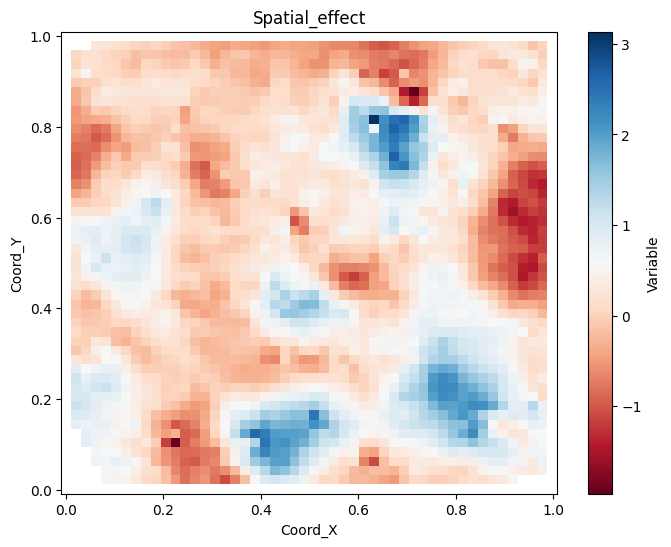

In [4]:
dict = {"Covariate": X, "Response": Y, "Spatial_effect":corerr}

for index, (name, variable) in enumerate(dict.items()):
    geospaNN.spatial_plot_surface(variable.detach().numpy().reshape(-1), coord.detach().numpy(),
                             grid_resolution = 50, method = "CloughTocher", cmap = "RdBu",
                             title = name, save_path = path, file_name = name + "_RdBu.png")

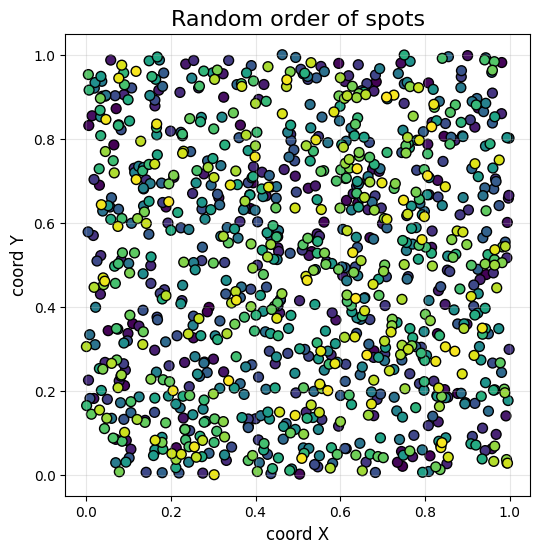

In [5]:
plt.figure(figsize=(6, 6))
sc = plt.scatter(coord[:,0], coord[:,1], c = range(n), cmap='viridis', s=50, edgecolor='k')

# Customize the plot
plt.title('Random order of spots', fontsize=16)
plt.xlabel('coord X', fontsize=12)
plt.ylabel('coord Y', fontsize=12)
plt.grid(alpha=0.3)
plt.savefig(path + "order_none.png")

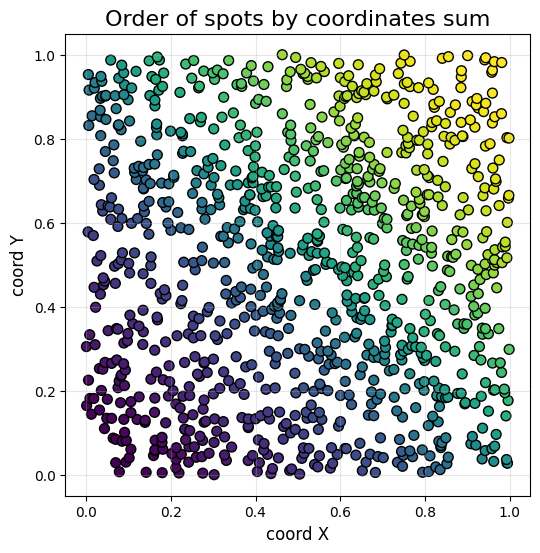

In [6]:
_, _, _, order = geospaNN.spatial_order(X, Y, coord, method='coord-sum')
plt.figure(figsize=(6, 6))
sc = plt.scatter(coord[order,0], coord[order,1], c = range(n), cmap='viridis', s=50, edgecolor='k')
# Customize the plot
plt.title('Order of spots by coordinates sum', fontsize=16)
plt.xlabel('coord X', fontsize=12)
plt.ylabel('coord Y', fontsize=12)
plt.grid(alpha=0.3)
plt.savefig(path + "order_coord-sum.png")

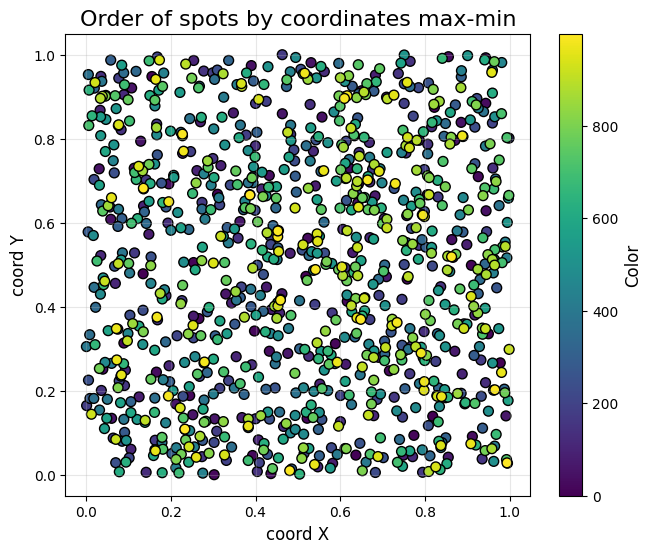

In [7]:
random.seed(2024)
_, _, _, order = geospaNN.spatial_order(X, Y, coord, method='max-min')
plt.figure(figsize=(7.5, 6))
sc = plt.scatter(coord[order,0], coord[order,1], c = range(n), cmap='viridis', s=50, edgecolor='k')
cbar = plt.colorbar(sc)
cbar.set_label('Color', fontsize=12)
# Customize the plot
plt.title('Order of spots by coordinates max-min', fontsize=16)
plt.xlabel('coord X', fontsize=12)
plt.ylabel('coord Y', fontsize=12)
plt.grid(alpha=0.3)
plt.savefig(path + "order_max-min.png")

In [8]:
data = geospaNN.make_graph(X, Y, coord, nn, Ind_list = None)

torch.manual_seed(2024)
np.random.seed(0)
data_train, data_val, data_test = geospaNN.split_data(X, Y, coord, neighbor_size=nn, 
                                                      test_proportion=0.2, val_proportion=0.2)

tensor([[0.4591],
        [0.2167],
        [0.6578],
        [0.4146],
        [0.6461]])

In [9]:
torch.manual_seed(2025)
_, _, coord_simp, _, corerr_simp = geospaNN.Simulation(n, p, nn, funXY, 
                                                       torch.tensor([1,1.5,0.01]), range=[0, 10])
theta_hat = geospaNN.theta_update(corerr_simp, coord_simp, neighbor_size=20)

---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 1000 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[0.88942914 1.74742522 0.01030131]


In [10]:
torch.manual_seed(2024)
mlp_nn = torch.nn.Sequential(
    torch.nn.Linear(p, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
nn_model = geospaNN.nn_train(mlp_nn, lr=0.01, min_delta=0.001)
training_log = nn_model.train(data_train, data_val, data_test, seed = 2025)
theta0 = geospaNN.theta_update(mlp_nn(data_train.x).squeeze() - data_train.y, 
                               data_train.pos, neighbor_size=20)

Epoch 00030: reducing learning rate of group 0 to 5.0000e-03.
INFO: Early stopping
End at epoch33
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[0.182681   6.67337675 0.13378453]


In [11]:
torch.manual_seed(2024)
mlp_nngls = torch.nn.Sequential(
    torch.nn.Linear(p, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 1),
)
model = geospaNN.nngls(p=p, neighbor_size=nn, coord_dimensions=2, mlp=mlp_nngls, 
                       theta=torch.tensor(theta0))
nngls_model = geospaNN.nngls_train(model, lr=0.1, min_delta=0.001)
training_log = nngls_model.train(data_train, data_val, data_test, epoch_num= 200, 
                                 Update_init=10, Update_step=2, seed = 2025)
theta1 = geospaNN.theta_update(mlp_nngls(data_train.x).squeeze() - data_train.y,
                               data_train.pos, neighbor_size=20)

---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of covariates 1 (including intercept if specified).

Using the exponential spatial correlation model.

Using 15 nearest neighbors.



Source not compiled with OpenMP support.
----------------------------------------
	Building neighbor index
----------------------------------------
	Performing optimization
----------------------------------------
	Processing optimizers
----------------------------------------
Theta estimated as
[ 1.24232833 15.51145856  0.07333078]
to
[ 1.24232833 15.51145856  0.07333078]
Epoch 00012: reducing learning rate of group 0 to 5.0000e-02.
---------------------------------------- 
	Ordering Coordinates 
----------------------------------------
	Model description
----------------------------------------
BRISC model fit with 600 observations.

Number of

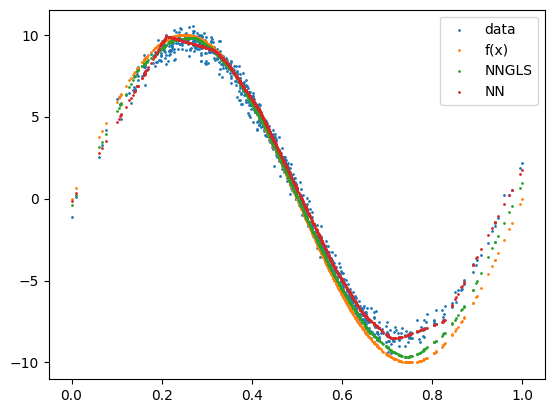

In [12]:
estimate = model.estimate(X)
plt.clf()
plt.scatter(X.detach().numpy(), Y.detach().numpy(), s=1, label='data')
plt.scatter(X.detach().numpy(), funXY(X.detach().numpy()), s=1, label='f(x)')
plt.scatter(X.detach().numpy(), estimate, s=1, label='NNGLS')
plt.scatter(X.detach().numpy(), mlp_nn(X).detach().numpy(), s=1, label='NN')
plt.legend()
plt.savefig(path + 'Estimation.png')

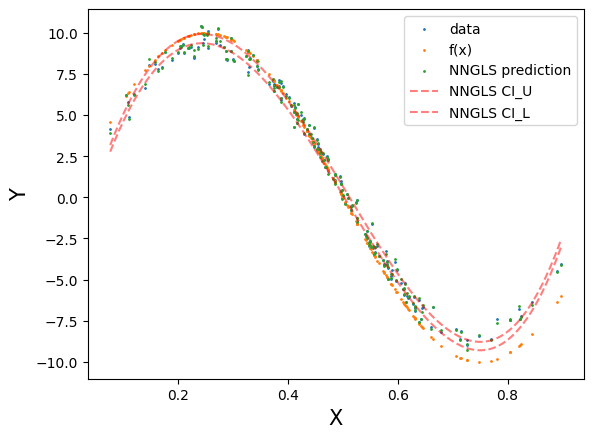

In [13]:
[test_predict, test_CI_U, test_CI_L] = model.predict(data_train, data_test, CI = True)
x_np = data_test.x.detach().numpy().reshape(-1)
x_smooth = np.linspace(x_np.min(), x_np.max(), 200)  # Create finer x-points
degree = 4
U_fit = np.polyfit(x_np, test_CI_U, degree)
L_fit = np.polyfit(x_np, test_CI_L, degree)

# Evaluate the polynomial on a smooth grid
y_smooth_U = np.polyval(U_fit, x_smooth)
y_smooth_L = np.polyval(L_fit, x_smooth)

plt.clf()
plt.scatter(data_test.x.detach().numpy(), data_test.y.detach().numpy(), s=1, label='data')
plt.scatter(data_test.x.detach().numpy(), funXY(data_test.x.detach().numpy()), s=1, label='f(x)')
plt.scatter(data_test.x.detach().numpy(), test_predict.detach().numpy(), s=1, label='NNGLS prediction')
plt.plot(x_smooth, y_smooth_U, linestyle='--', label='NNGLS CI_U', color = 'red', alpha = 0.5)
plt.plot(x_smooth, y_smooth_L, linestyle='--', label='NNGLS CI_L', color = 'red', alpha = 0.5)
plt.legend()
plt.xlabel("X", fontsize=15)
plt.ylabel("Y", fontsize=15)
plt.savefig(path + "Prediction_CI.png")

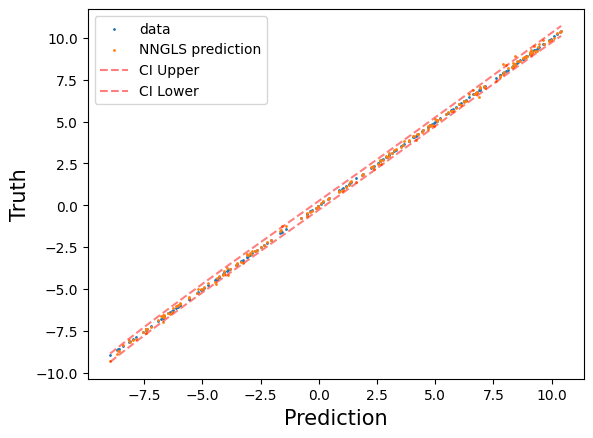

In [14]:
x_np = data_test.y.detach().numpy().reshape(-1)
degree = 4
x_smooth = np.linspace(x_np.min(), x_np.max(), 200)  # Create finer x-points
U_fit = np.polyfit(x_np, test_CI_U, degree)
L_fit = np.polyfit(x_np, test_CI_L, degree)
# Evaluate the polynomial on a smooth grid
y_smooth_U = np.polyval(U_fit, x_smooth)
y_smooth_L = np.polyval(L_fit, x_smooth)

plt.clf()
plt.scatter(data_test.y.detach().numpy(), data_test.y.detach().numpy(), s=1, label='data')
plt.scatter(data_test.y.detach().numpy(), test_predict.detach().numpy(), s=1, label='NNGLS prediction')
plt.plot(x_smooth, y_smooth_U, linestyle='--', label='CI Upper', color = 'red', alpha = 0.5)
plt.plot(x_smooth, y_smooth_L, linestyle='--', label='CI Lower', color = 'red', alpha = 0.5)
plt.legend()
plt.xlabel("Prediction", fontsize=15)
plt.ylabel("Truth", fontsize=15)
plt.savefig(path + "Prediction_vs_CI.png")

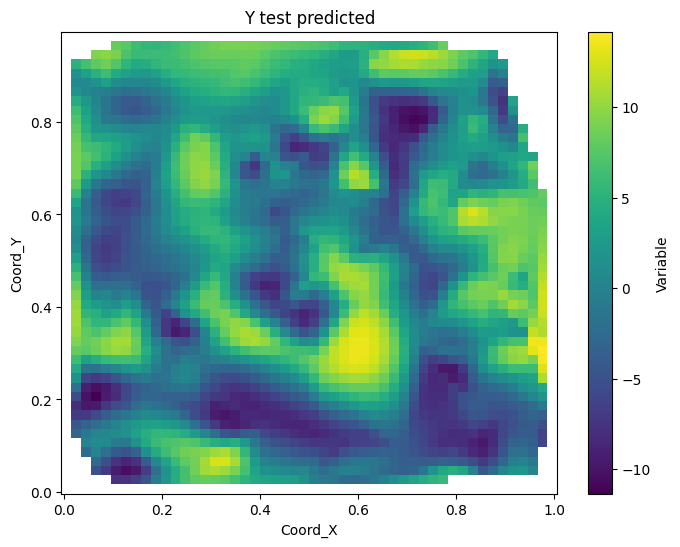

<Figure size 640x480 with 0 Axes>

<Figure size 800x600 with 0 Axes>

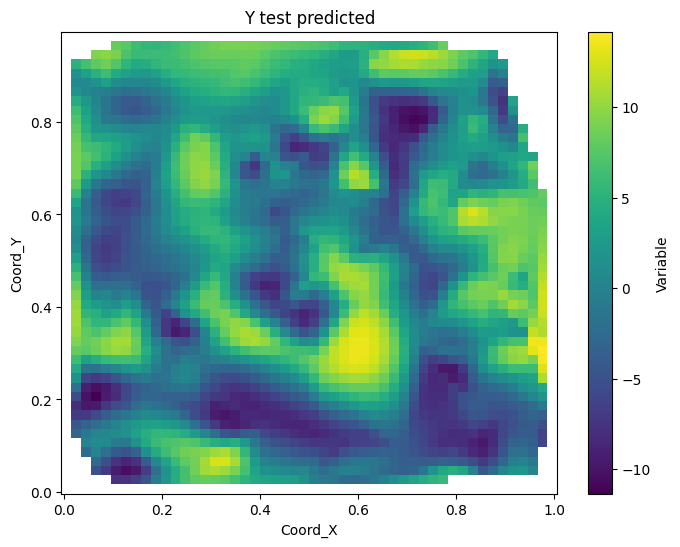

In [15]:
geospaNN.spatial_plot_surface(data_test.y.detach().numpy(), data_test.pos.detach().numpy(),
                              grid_resolution = 50, method = "CloughTocher",
                              title = "Y test", save_path = path, file_name = "Y_test" + ".png")
geospaNN.spatial_plot_surface(test_predict.detach().numpy(), data_test.pos.detach().numpy(),
                              grid_resolution = 50, method = "CloughTocher",
                              title = "Y test predicted", save_path = path, file_name = "Y_test_predicted" + ".png")

In [16]:
def plot_log(training_log, theta):
    epoch = len(training_log["val_loss"])
    training_log["epoch"] = list(range(1, epoch + 1))
    training_log = pd.DataFrame(training_log)

    # Melting the dataframe to make it suitable for seaborn plotting
    training_log_melted = training_log[["epoch", "val_loss"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')
    # Plotting with seaborn
    # Creating two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    sns.lineplot(ax=axes[0], data=training_log_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)

    axes[0].set_title('Validation and prediction loss over Epochs (Log Scale) with Benchmark', fontsize=14)
    axes[0].set_xlabel('Epoch', fontsize=15)
    axes[0].set_ylabel('Value (Log Scale)', fontsize=15)
    axes[0].set_yscale('log')
    axes[0].legend(prop={'size': 15})
    axes[0].tick_params(labelsize=14)
    axes[0].grid(True)

    # Second plot (sigma, phi, tau)
    kernel_params_melted = training_log[["epoch", "sigma", "phi", "tau"]].melt(id_vars='epoch', var_name='Variable', value_name='Value')
    ground_truth = {'sigma': theta[0], 'phi': theta[1], 'tau': theta[2]}
    sns.lineplot(ax=axes[1], data=kernel_params_melted, x='epoch', y='Value', hue='Variable', style='Variable', markers=False, dashes=False)
    palette = sns.color_palette()
    for i, (param, gt_value) in enumerate(ground_truth.items()):
        axes[1].hlines(y=gt_value, xmin=1, xmax=epoch, color=palette[i], linestyle='--')
    axes[1].set_title('Parameter Values over Epochs with Ground Truth', fontsize=14)
    axes[1].set_xlabel('Epoch', fontsize=15)
    axes[1].set_ylabel('Value', fontsize=15)
    axes[1].set_yscale('log')
    axes[1].legend(prop={'size': 15})
    axes[1].tick_params(labelsize=14)
    axes[1].grid(True)

    plt.tight_layout()
    

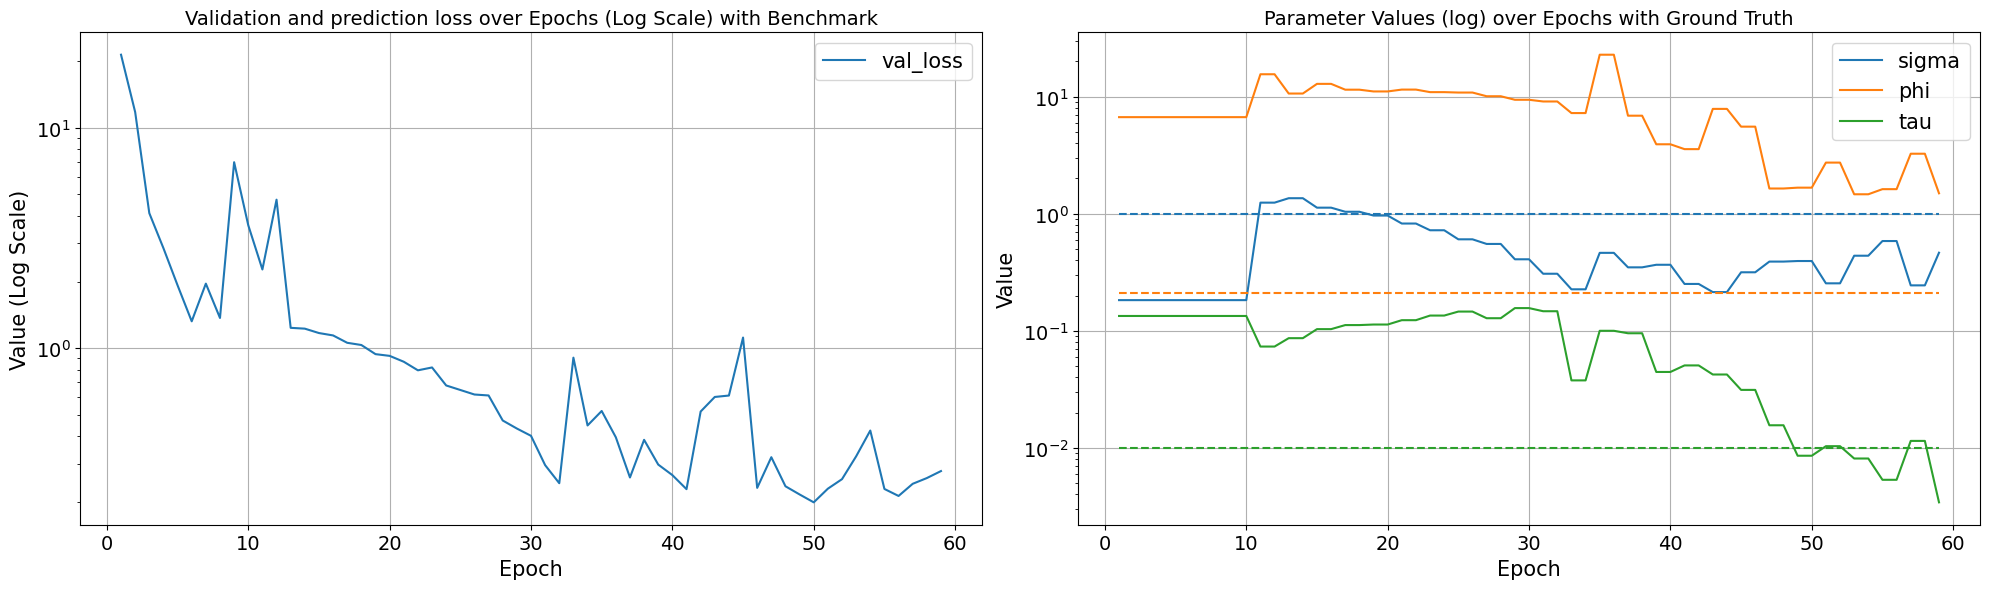

In [17]:
geospaNN.plot_log(training_log, theta, path, save = True)